<h1>KNN Classification</h1>

<h3>1. Load and preprocess the data</h3>

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.decomposition import PCA

In [29]:
data = pd.read_csv('/content/drive/MyDrive/spotify top tracks/tracks_with_binary_target.csv')
data.drop(['top genre'], axis=1, inplace=True)
data.set_index(['title'], inplace=True)
data.head()

,artist,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity,is_dance_pop
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",Train,3.618665,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83,0
Love The Way You Lie,Eminem,42.795820,95.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82,0
TiK ToK,Kesha,6.235482,82.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80,1
Bad Romance,Lady Gaga,16.716518,90.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79,1
Just the Way You Are,Bruno Mars,29.381079,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78,0


In [161]:
data.describe()

,artist,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity,is_dance_pop
count,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.000000,653.00000,653.000000,653.000000,653.000000,653.000000,653.000000
mean,102.222052,16.348585,84.967841,2015.006126,118.633266,69.771057,64.938132,-5.628323,17.918469,52.48170,222.782187,15.191469,8.668897,67.831547,0.514548
std,60.348589,15.500729,7.968143,2.889046,24.825330,16.432632,13.444986,2.770043,13.498254,22.44883,34.722627,21.449299,7.945333,14.827509,0.500171
min,0.000000,0.044695,53.000000,2010.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.00000,134.000000,0.000000,0.000000,0.000000,0.000000
25%,49.000000,5.400656,81.000000,2013.000000,100.000000,60.000000,58.000000,-6.903000,9.000000,35.00000,200.000000,2.000000,4.000000,61.000000,0.000000
50%,100.000000,10.515901,86.000000,2015.000000,120.000000,73.000000,67.000000,-5.000000,12.000000,53.00000,219.000000,6.000000,5.780000,70.000000,1.000000
75%,153.000000,22.563709,91.000000,2017.000000,129.000000,81.000000,74.000000,-4.000000,24.000000,69.40000,238.000000,19.000000,10.000000,78.000000,1.000000
max,211.000000,77.890588,100.000000,2020.000000,206.000000,98.000000,97.000000,-2.000000,79.200000,98.00000,424.000000,99.000000,48.700000,99.000000,1.000000


Because the KNN algorithm cannot work with categorical features expressed as string values, we need to use LabelEncoder to encode them to integer values. I am not using OneHotEncoding since the number of possible categories for artist is large. <br>
Additionally, scaling is critical for the algorithm so it is performed next.

In [30]:
data[['artist']] = data[['artist']].apply(LabelEncoder().fit_transform)
data.head()

,artist,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity,is_dance_pop
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",200,3.618665,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83,0
Love The Way You Lie,58,42.795820,95.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82,0
TiK ToK,103,6.235482,82.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80,1
Bad Romance,108,16.716518,90.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79,1
Just the Way You Are,26,29.381079,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78,0


In [115]:
X_train, X_test, Y_train, Y_test = train_test_split(
    data[data.columns.drop(['is_dance_pop'])],
    data['is_dance_pop'],
    test_size=0.2,
    random_state=24
)

In [116]:
X, Y = data[data.columns.drop(['is_dance_pop'])], data['is_dance_pop']

In [117]:
scaler = MinMaxScaler()
scaler.fit(X_train[X_train.columns.drop(['artist', 'year'])])
X_train[X_train.columns.drop(['artist', 'year'])] = scaler.transform(X_train[X_train.columns.drop(['artist', 'year'])] )
X_test[X_test.columns.drop(['artist', 'year'])] = scaler.transform(X_test[X_test.columns.drop(['artist', 'year'])] )
X[X.columns.drop(['artist', 'year'])] = scaler.transform(X[X.columns.drop(['artist', 'year'])])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


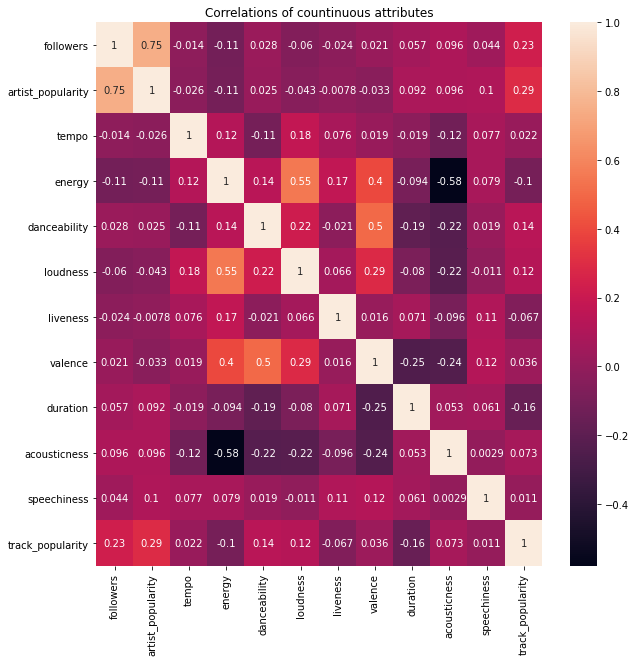

In [118]:
plt.figure(figsize=(10,10))
sns.heatmap(data[data.columns.drop(['artist', 'year', 'is_dance_pop'])].corr(), annot=True)
plt.title('Correlations of countinuous attributes')
plt.show()

<h3>2. KNN Classification</h3>

KNN does not make any assumptions about the data so testing correlations will not be of any benefit.

Since the data is of different types, we have: nominal, ordinal, interval and ration attributes, i am going to define a custom metric. <br>
Binary (target): is_dance_pop <br>
Nominal attributes: title(not used), artist<br>
Ordinal attributes: year (2010 - 2020)<br>
Interval: loudness<br>
Ratio: other

In [121]:
def custom_metric(x, y):
  score = 0
  val = (x[0]!=y[0])**2 #for artist (nominal)
  score += val
  count = 0

  for xi, yi in zip(x[1:], y[1:]):
    if count == 2:
      score += (abs((xi-yi) / 9))**2 #for year (ordinal)
    else:
      score += (xi-yi)**2
    count += 1

  return np.sqrt(score)

In [122]:
def cross_validation_model(X, Y, model):
  predicted = []
  actual = []
  folds = KFold(n_splits=5, shuffle=True, random_state=0)

  for train_ind, test_ind in folds.split(X):
    X_train = X.iloc[train_ind]
    Y_train = Y.iloc[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y.iloc[test_ind]
    model.fit(X_train, Y_train)
    predicted_vals = model.predict(X_test)
    predicted.extend(predicted_vals)
    actual.extend(Y_test.to_list())
  
  score = cross_val_score(clf, X, Y)

  return predicted, actual, score

In [123]:
errors = []
metrics = ['minkowski', 'manhattan', 'euclidean', 'cosine',custom_metric]

for metric in metrics:
  node = []
  for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i, metric=metric, p=3)
    knn.fit(X_train, Y_train)
    pred_i = knn.predict(X_test)
    node.append(np.mean(pred_i != Y_test))
  errors.append(node)   

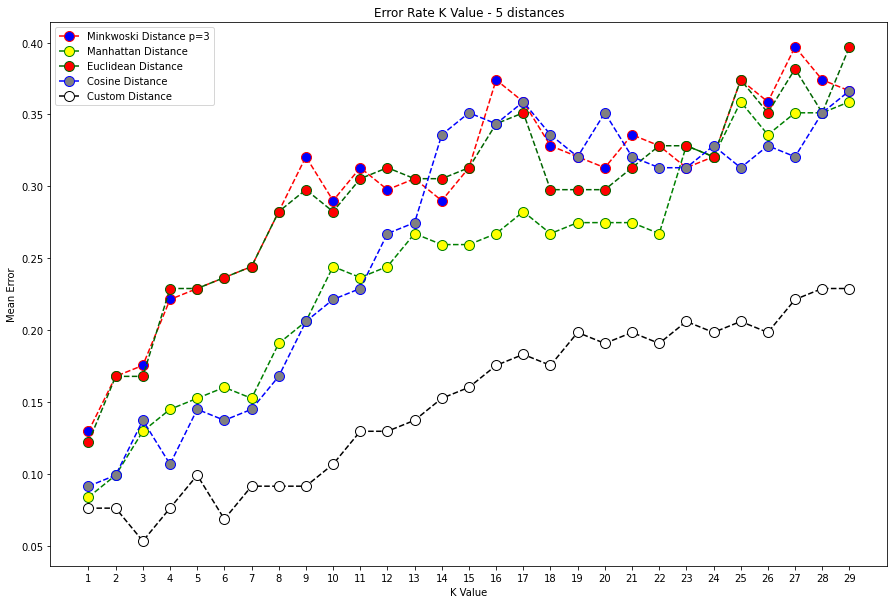

In [124]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, 30), errors[0], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label='Minkwoski Distance p=3')
plt.plot(range(1, 30), errors[1], color='green', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10, label='Manhattan Distance')
plt.plot(range(1, 30), errors[2], color='darkgreen', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10, label='Euclidean Distance')
plt.plot(range(1, 30), errors[3], color='blue', linestyle='dashed', marker='o',
         markerfacecolor='grey', markersize=10, label='Cosine Distance')
plt.plot(range(1, 30), errors[4], color='black', linestyle='dashed', marker='o',
         markerfacecolor='white', markersize=10, label='Custom Distance')
plt.title('Error Rate K Value - 5 distances')
plt.xlabel('K Value')
plt.xticks(range(1,30))
plt.ylabel('Mean Error')
plt.legend()
plt.show()

<h4>The custom metric has the lowest error for 3 neighbors. And it has the overall lowest average error compared to all of the other metrics which is expected since the data has attribtes of different types.</h4>

In [125]:
clf = KNeighborsClassifier(n_neighbors=3, metric=custom_metric)
clf.fit(X_train, Y_train)
y_pred_holdout = clf.predict(X_test)

In [126]:
print(classification_report(Y_test, y_pred_holdout))

              precision    recall  f1-score   support

           0       0.97      0.92      0.94        63
           1       0.93      0.97      0.95        68

    accuracy                           0.95       131
   macro avg       0.95      0.95      0.95       131
weighted avg       0.95      0.95      0.95       131



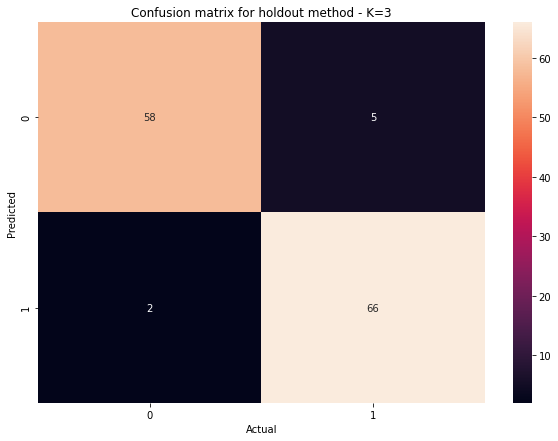

In [127]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(Y_test, y_pred_holdout), annot=True)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for holdout method - K=3')
plt.show()

In [79]:
cv_predictions, cv_actual, cv_score = cross_validation_model(X, Y, KNeighborsClassifier(n_neighbors=3, metric=custom_metric))

In [80]:
cv_score

array([0.85496183, 0.81679389, 0.85496183, 0.82307692, 0.76153846])

In [81]:
print(classification_report(cv_actual, cv_predictions))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94       317
           1       0.92      0.98      0.95       336

    accuracy                           0.94       653
   macro avg       0.95      0.94      0.94       653
weighted avg       0.95      0.94      0.94       653



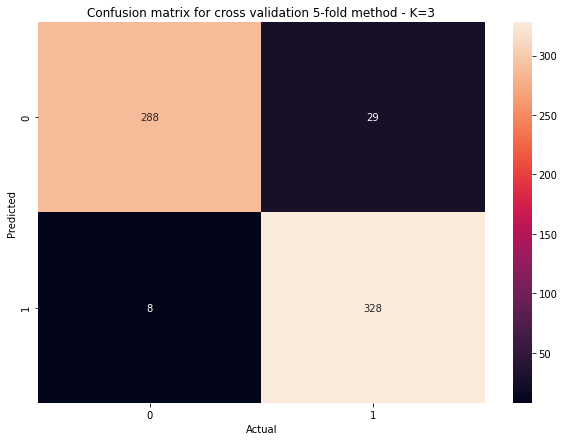

In [128]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(cv_actual, cv_predictions), annot=True, fmt='.5g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for cross validation 5-fold method - K=3')
plt.show()

The scores are roughly the same on the heldout data and on cross validation. We may assume that the model is not overfitting.

KNN has a problem with high dimensional data. Let's see how it performes with PCA reduced dimensionality of the data set.

In [131]:
pca = PCA(5)
X_decomposed = pca.fit_transform(X)

In [146]:
X_train_dec, X_test_dec, Y_train_dec, Y_test_dec = train_test_split(
    X_decomposed,
    Y,
    test_size = 0.2,
    random_state = 0
)

In [142]:
pca.explained_variance_ratio_

array([9.97624562e-01, 2.28848316e-03, 2.24158357e-05, 1.69304589e-05,
       1.13709841e-05])

The custom metric does not make sense in this case, so we will not use it.

In [147]:
errors = []
metrics = ['minkowski', 'manhattan', 'euclidean', 'cosine']

for metric in metrics:
  node = []
  for i in range(1, 30):
    knn = KNeighborsClassifier(n_neighbors=i, metric=metric, p=3)
    knn.fit(X_train_dec, Y_train_dec)
    pred_i = knn.predict(X_test_dec)
    node.append(np.mean(pred_i != Y_test_dec))
  errors.append(node)   

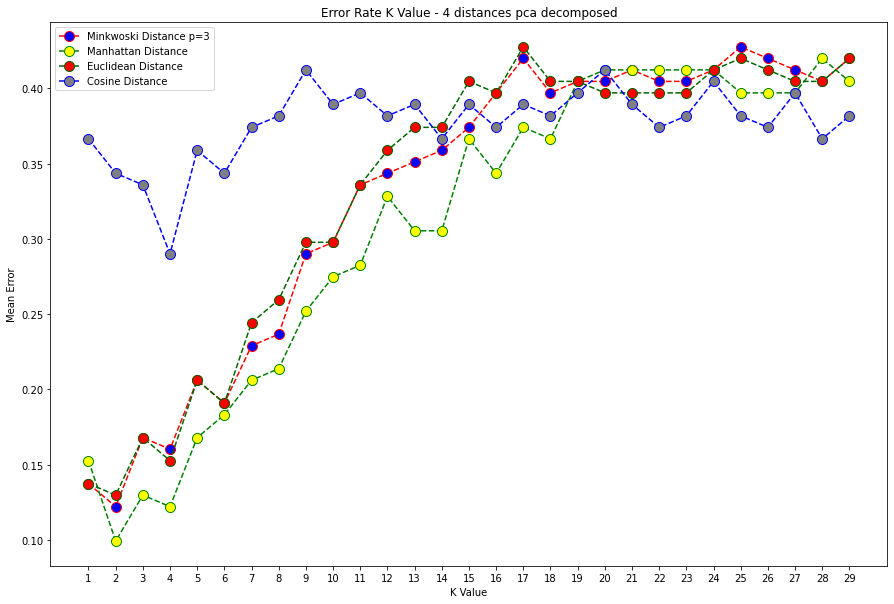

In [148]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, 30), errors[0], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label='Minkwoski Distance p=3')
plt.plot(range(1, 30), errors[1], color='green', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10, label='Manhattan Distance')
plt.plot(range(1, 30), errors[2], color='darkgreen', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10, label='Euclidean Distance')
plt.plot(range(1, 30), errors[3], color='blue', linestyle='dashed', marker='o',
         markerfacecolor='grey', markersize=10, label='Cosine Distance')
plt.title('Error Rate K Value - 4 distances pca decomposed')
plt.xlabel('K Value')
plt.xticks(range(1,30))
plt.ylabel('Mean Error')
plt.legend()
plt.show()

We can see that the cosine distance is the worst, and manhattan distance has the best results.

In [154]:
X_decomposed = pd.DataFrame(X_decomposed)

In [158]:
knn_dec = KNeighborsClassifier(n_neighbors=2, metric='manhattan')
knn_dec.fit(X_train_dec, Y_train_dec)
y_pred_dec_hold = knn_dec.predict(X_test_dec)

In [159]:
print(classification_report(Y_test_dec, y_pred_dec_hold))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91        71
           1       0.90      0.88      0.89        60

    accuracy                           0.90       131
   macro avg       0.90      0.90      0.90       131
weighted avg       0.90      0.90      0.90       131



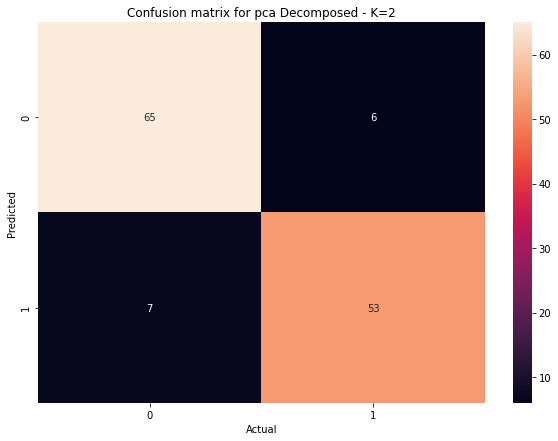

In [160]:
plt.figure(figsize=(10,7))
sns.heatmap(confusion_matrix(Y_test_dec, y_pred_dec_hold), annot=True, fmt='.5g')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion matrix for pca Decomposed - K=2')
plt.show()

We can see that the method performs a bit worse with the pca decomposed features than with the original features. But this time it uses manhattan distance insead of the custom distance.

<h3>3. KNN Regression</h3>

This time lets try regression, with followers as the target attribute.

In [217]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [165]:
data = pd.read_csv('/content/drive/MyDrive/spotify top tracks/tracks_with_binary_target.csv')
data.drop(['is_dance_pop'], axis=1, inplace=True)
data.set_index(['title'], inplace=True)
data.head()

,artist,top genre,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",Train,neo mellow,3.618665,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83
Love The Way You Lie,Eminem,detroit hip hop,42.795820,95.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82
TiK ToK,Kesha,dance pop,6.235482,82.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80
Bad Romance,Lady Gaga,dance pop,16.716518,90.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79
Just the Way You Are,Bruno Mars,pop,29.381079,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78


Encode the values of artist and top genre with label encoder and then scale.

In [169]:
data[['artist', 'top genre']] = data[['artist', 'top genre']].apply(LabelEncoder().fit_transform)
data.head()

,artist,top genre,followers,artist_popularity,year,tempo,energy,danceability,loudness,liveness,valence,duration,acousticness,speechiness,track_popularity
title,,,,,,,,,,,,,,,
"Hey, Soul Sister",200,53,3.618665,78.0,2010,97.0,89.0,67.0,-4.0,8.0,80.0,217.0,19.0,4.0,83
Love The Way You Lie,58,30,42.795820,95.0,2010,87.0,93.0,75.0,-5.0,52.0,64.0,263.0,24.0,23.0,82
TiK ToK,103,28,6.235482,82.0,2010,120.0,84.0,76.0,-3.0,29.0,71.0,200.0,10.0,14.0,80
Bad Romance,108,28,16.716518,90.0,2010,119.0,92.0,70.0,-4.0,8.0,71.0,295.0,0.0,4.0,79
Just the Way You Are,26,57,29.381079,93.0,2010,109.0,84.0,64.0,-5.0,9.0,43.0,221.0,2.0,4.0,78


In [171]:
X = data.drop('followers', axis=1)
Y = data['followers']

In [209]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size = 0.2,
    random_state = 5
)

In [210]:
scaler.fit(X_train[X_train.columns.drop(['artist', 'top genre', 'year'])])
X_train[X_train.columns.drop(['artist', 'top genre', 'year'])] = scaler.transform(X_train[X_train.columns.drop(['artist', 'top genre', 'year'])])
X_test[X_test.columns.drop(['artist', 'top genre', 'year'])] = scaler.transform(X_test[X_test.columns.drop(['artist', 'top genre', 'year'])])
X[X.columns.drop(['artist', 'top genre', 'year'])] =  scaler.transform(X[X.columns.drop(['artist', 'top genre', 'year'])])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [211]:
def custom_metric_2(x, y):
  score = 0
  score += (x[0]!=y[0])**2 #for artist (nominal)
  score += (x[1]!=y[1])**2 #for top genre (nominal)
  
  count = 0
  for xi, yi in zip(x[2:], y[2:]):
    if count == 1:
      score += (abs((xi-yi) / 9))**2 #for year (ordinal)
    else:
      score += (xi-yi)**2
    count += 1

  return np.sqrt(score)

In [212]:
errors = []
rmse = []
metrics = ['minkowski', 'manhattan', 'euclidean', 'cosine', custom_metric_2]

for metric in metrics:
  inner_error = []
  inner_rmse = []
  for i in range(1, 30):
    knn = KNeighborsRegressor(n_neighbors=i, metric=metric, p=3)
    knn.fit(X_train, Y_train)
    pred_i = knn.predict(X_test)
    inner_error.append(np.mean(abs(pred_i - Y_test)))
    inner_rmse.append(np.sqrt(mean_squared_error(pred_i, Y_test)))
  errors.append(inner_error)
  rmse.append(inner_rmse)

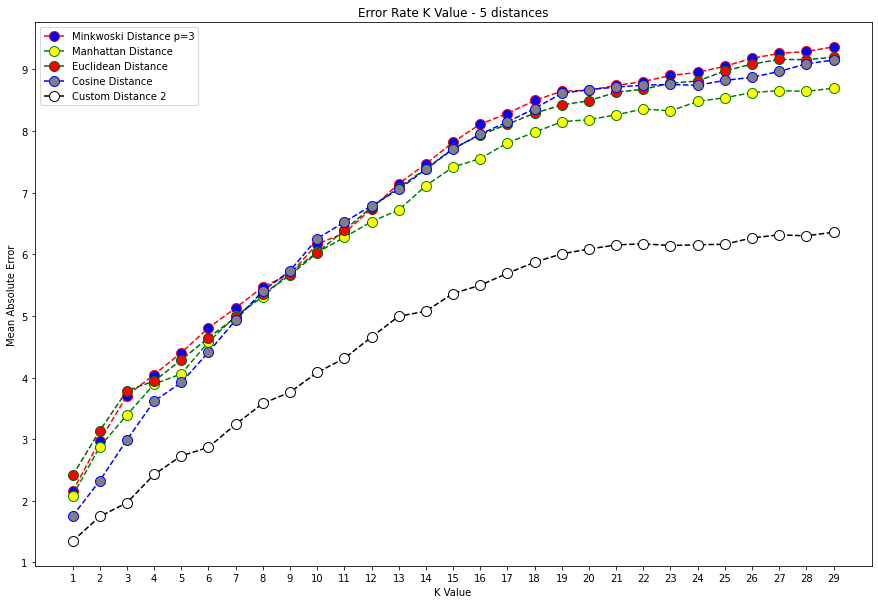

In [213]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, 30), errors[0], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label='Minkwoski Distance p=3')
plt.plot(range(1, 30), errors[1], color='green', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10, label='Manhattan Distance')
plt.plot(range(1, 30), errors[2], color='darkgreen', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10, label='Euclidean Distance')
plt.plot(range(1, 30), errors[3], color='blue', linestyle='dashed', marker='o',
         markerfacecolor='grey', markersize=10, label='Cosine Distance')
plt.plot(range(1, 30), errors[4], color='black', linestyle='dashed', marker='o',
         markerfacecolor='white', markersize=10, label='Custom Distance 2')
plt.title('Error Rate K Value - 5 distances')
plt.xlabel('K Value')
plt.xticks(range(1,30))
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

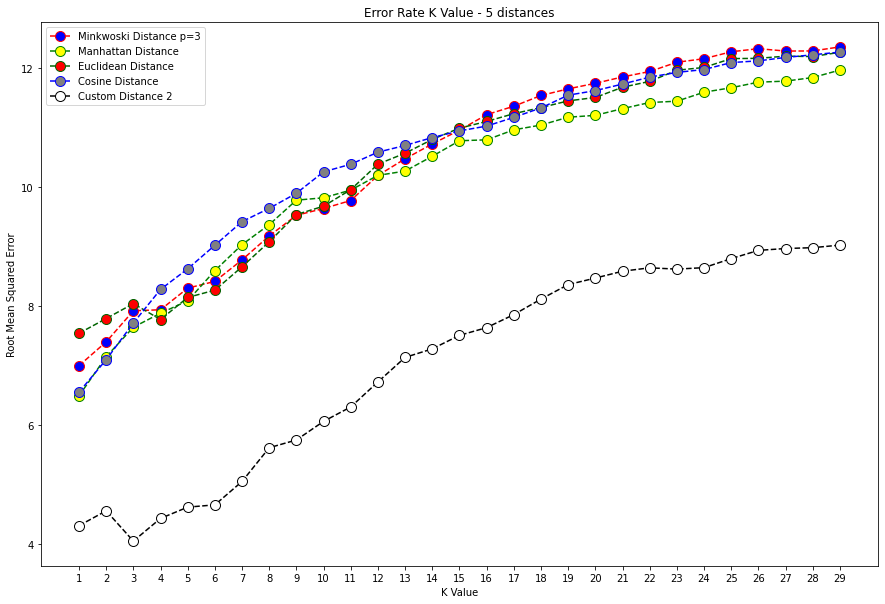

In [214]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, 30), rmse[0], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label='Minkwoski Distance p=3')
plt.plot(range(1, 30), rmse[1], color='green', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10, label='Manhattan Distance')
plt.plot(range(1, 30), rmse[2], color='darkgreen', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10, label='Euclidean Distance')
plt.plot(range(1, 30), rmse[3], color='blue', linestyle='dashed', marker='o',
         markerfacecolor='grey', markersize=10, label='Cosine Distance')
plt.plot(range(1, 30), rmse[4], color='black', linestyle='dashed', marker='o',
         markerfacecolor='white', markersize=10, label='Custom Distance 2')
plt.title('Error Rate K Value - 5 distances')
plt.xlabel('K Value')
plt.xticks(range(1,30))
plt.ylabel('Root Mean Squared Error')
plt.legend()
plt.show()

The custom metric is again way better than the other metrics. The mean absolute error grows logarithmically with the number of neighbors. Whereas for rmse, for k=3 the lowest error is achieved.

In [216]:
knn_reg = KNeighborsRegressor(n_neighbors=3, metric=custom_metric_2)
knn_reg.fit(X_train, Y_train)
y_pred_holdout = knn_reg.predict(X_test)

In [219]:
print(f'RMSE: {np.sqrt(mean_squared_error(Y_test, y_pred_holdout))}')
print(f'MAE: {mean_absolute_error(Y_test, y_pred_holdout)}')
print(f'R2 score: {r2_score(Y_test, y_pred_holdout)}')

RMSE: 4.042340052804095
MAE: 1.9691188676844786
R2 score: 0.9252398127338027


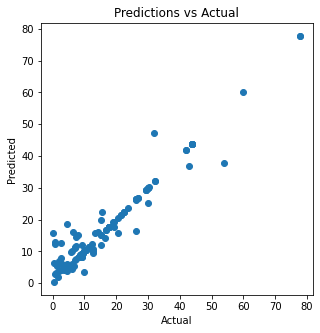

In [221]:
plt.figure(figsize=(5,5))
plt.scatter(Y_test, y_pred_holdout)
plt.axis('square')
plt.title('Predictions vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [236]:
def cross_validation_model_reg(X, Y, model):
  predicted = []
  actual = []
  folds = KFold(n_splits=5, shuffle=True, random_state=0)

  for train_ind, test_ind in folds.split(X):
    X_train = X.iloc[train_ind]
    Y_train = Y.iloc[train_ind]
    X_test = X.iloc[test_ind]
    Y_test = Y.iloc[test_ind]
    model.fit(X_train, Y_train)
    predicted_vals = model.predict(X_test)
    predicted.extend(predicted_vals)
    actual.extend(Y_test.to_list())

  return predicted, actual

In [237]:
pred_cv, act_cv = cross_validation_model_reg(X, Y, knn_reg)

In [238]:
print(f'RMSE: {np.sqrt(mean_squared_error(pred_cv, act_cv))}')
print(f'MAE: {mean_absolute_error(pred_cv, act_cv)}')
print(f'R2 score: {r2_score(pred_cv, act_cv)}')

RMSE: 5.391496744671657
MAE: 2.4539597493619194
R2 score: 0.8657928334120866


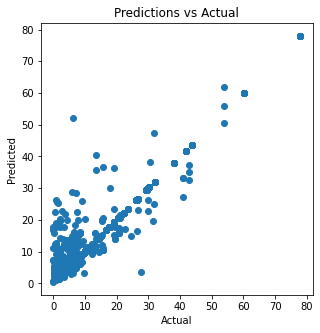

In [239]:
plt.figure(figsize=(5,5))
plt.scatter(act_cv, pred_cv)
plt.axis('square')
plt.title('Predictions vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

<h3>PCA decomposed</h3>

In [242]:
X_dec = pd.DataFrame(pca.fit_transform(X))
print(pca.explained_variance_ratio_)

[9.49999575e-01 4.77808389e-02 2.12786912e-03 2.62026436e-05
 1.20542783e-05]


In [248]:
X_dec_trin, X_dec_test, Y_dec_train, Y_dec_test = train_test_split(
    X_dec,
    Y,
    test_size=0.2,
    random_state=24
)

In [249]:
errors = []
rmse = []
metrics = ['minkowski', 'manhattan', 'euclidean', 'cosine', custom_metric_2]

for metric in metrics:
  inner_error = []
  inner_rmse = []
  for i in range(1, 50):
    knn = KNeighborsRegressor(n_neighbors=i, metric=metric, p=3)
    knn.fit(X_dec_trin, Y_dec_train)
    pred_i = knn.predict(X_dec_test)
    inner_error.append(np.mean(abs(pred_i - Y_test_dec)))
    inner_rmse.append(np.sqrt(mean_squared_error(pred_i, Y_test_dec)))
  errors.append(inner_error)
  rmse.append(inner_rmse)

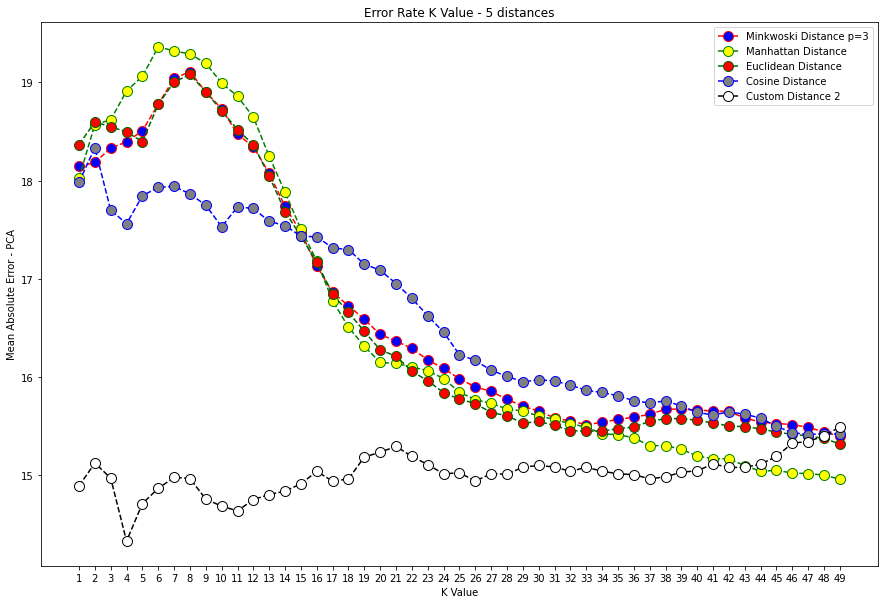

In [253]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, 50), errors[0], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label='Minkwoski Distance p=3')
plt.plot(range(1, 50), errors[1], color='green', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10, label='Manhattan Distance')
plt.plot(range(1, 50), errors[2], color='darkgreen', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10, label='Euclidean Distance')
plt.plot(range(1, 50), errors[3], color='blue', linestyle='dashed', marker='o',
         markerfacecolor='grey', markersize=10, label='Cosine Distance')
plt.plot(range(1, 50), errors[4], color='black', linestyle='dashed', marker='o',
         markerfacecolor='white', markersize=10, label='Custom Distance 2')
plt.title('Error Rate K Value - 5 distances')
plt.xlabel('K Value')
plt.xticks(range(1,50))
plt.ylabel('Mean Absolute Error - PCA')
plt.legend()
plt.show()

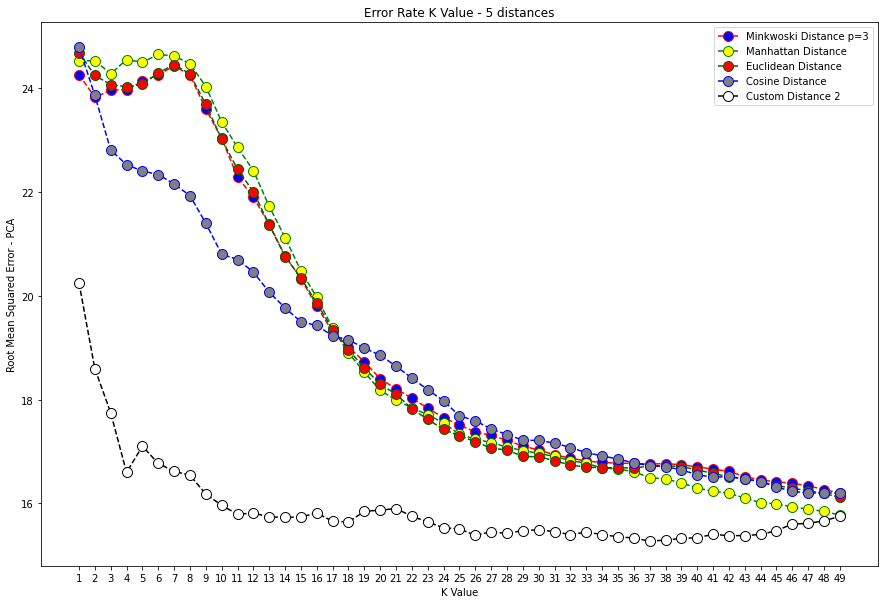

In [252]:
plt.figure(figsize=(15, 10))
plt.plot(range(1, 50), rmse[0], color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10, label='Minkwoski Distance p=3')
plt.plot(range(1, 50), rmse[1], color='green', linestyle='dashed', marker='o',
         markerfacecolor='yellow', markersize=10, label='Manhattan Distance')
plt.plot(range(1, 50), rmse[2], color='darkgreen', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10, label='Euclidean Distance')
plt.plot(range(1, 50), rmse[3], color='blue', linestyle='dashed', marker='o',
         markerfacecolor='grey', markersize=10, label='Cosine Distance')
plt.plot(range(1, 50), rmse[4], color='black', linestyle='dashed', marker='o',
         markerfacecolor='white', markersize=10, label='Custom Distance 2')
plt.title('Error Rate K Value - 5 distances')
plt.xlabel('K Value')
plt.xticks(range(1,50))
plt.ylabel('Root Mean Squared Error - PCA')
plt.legend()
plt.show()

I am going to choose k=4 and metric = custom_metric_2 even though values 18 and 19 have a lower rmse, but they have higher mae values and may be more of an underfit.

In [255]:
knn_reg_pca = KNeighborsRegressor(n_neighbors=4, metric=custom_metric_2)
knn_reg_pca.fit(X_train, Y_train)
y_pred_pca = knn_reg_pca.predict(X_test)

In [257]:
print(f'RMSE: {np.sqrt(mean_squared_error(Y_test, y_pred_pca))}')
print(f'MAE: {mean_absolute_error(Y_test, y_pred_pca)}')
print(f'R2 score: {r2_score(Y_test, y_pred_pca)}')

RMSE: 4.424104614342021
MAE: 2.427437935114504
R2 score: 0.9104520873591135


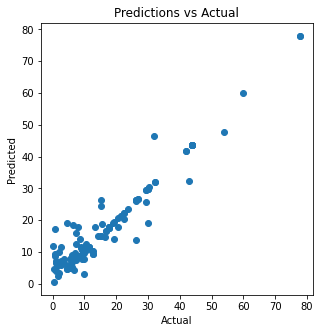

In [258]:
plt.figure(figsize=(5,5))
plt.scatter(Y_test, y_pred_pca)
plt.axis('square')
plt.title('Predictions vs Actual')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

These scores are very close to the ones with the original data.